# Pre processing

In [1]:
!pip install split_folders

In [2]:
import splitfolders

In [3]:
input_folder = r"C:\Users\kethu\Videos\data-set\Input_dataset"
output = r"C:\Users\kethu\Videos\data-set\processed_data"
splitfolders.ratio(input_folder, output, seed=42, ratio=(.6, .2, .2))

Copying files: 15515 files [00:46, 332.18 files/s]


In [4]:
help(splitfolders.ratio)

Help on function ratio in module splitfolders.split:

ratio(input, output='output', seed=1337, ratio=(0.8, 0.1, 0.1), group_prefix=None, move=False)



# ResNet50

In [5]:
# Libraries

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D, MaxPool2D, BatchNormalization
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

In [6]:
# Define parameters
img_height, img_width = (244,244)
BATCH_SIZE = 32
EPOCHS = 20

In [7]:
train_dir = r"C:\Users\kethu\Videos\data-set\processed_data\train"
val_dir = r"C:\Users\kethu\Videos\data-set\processed_data\val"
test_dir = r"C:\Users\kethu\Videos\data-set\processed_data\test"

In [8]:
# train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#     rescale=1./255,
#     rotation_range=20,
#     zoom_range=0.15,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.15,
#     horizontal_flip=True,
#     fill_mode="nearest",
#     validation_split=0.4 
# )
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  
    rotation_range=30,  
    zoom_range=0.2,  
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,  
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.4
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
) # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir ,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
) # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    subset='validation'
) # set as validation data

Found 5589 images belonging to 12 classes.
Found 1237 images belonging to 12 classes.
Found 1239 images belonging to 12 classes.


In [9]:
for x, y in test_generator:
    print(x.shape)
    break  # Remove this to iterate over all batches


(1, 244, 244, 3)


In [10]:
num_classes = len(train_generator.class_indices)
print(num_classes)

12


In [12]:
# Load ResNet50 without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Flatten the output from the base model
x = Flatten()(base_model.output)

# Add layers on top of ResNet50
# Add the first hidden layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

# Add the second hidden layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) 

# Add the third hidden layer
x = Dense(128, activation='relu')(x)

# Add the final output layer (assuming a classification task with N classes)
output = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the layers of ResNet50 
for layer in base_model.layers:
    layer.trainable = False
    
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 244, 244, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 250, 250, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 122, 122, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 122, 122, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 122, 122, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 124, 124, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 61, 61, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 61, 61, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 61, 61, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 61, 61, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 61, 61, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 61, 61, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 61, 61, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 61, 61, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 61, 61, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 90,862,860 (346.61 MB)

 Trainable params: 67,275,148 (256.63 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20


D:\App\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 469s 2s/step - accuracy: 0.4247 - loss: 2.6194
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.6981 - loss: 0.9637
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.7385 - loss: 0.8581
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.8096 - loss: 0.6637
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.8226 - loss: 0.5809
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.8433 - loss: 0.5656
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.8609 - loss: 0.4827
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.8719 - loss: 0.4428
Epoch 9/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.8812 - loss: 0.4124
Epoch 10/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.8916 - loss: 0.3920
Epoch 11/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.8980 - loss: 0.3746
Epoch 12/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/ste

In [13]:
model.save(r'C:\Users\kethu\Videos\data-set\Saved_model\ResNet50.h5')

In [14]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

1239/1239 - 99s - 80ms/step - accuracy: 0.8935 - loss: 0.3968
Test Accuracy: 89.35%


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1

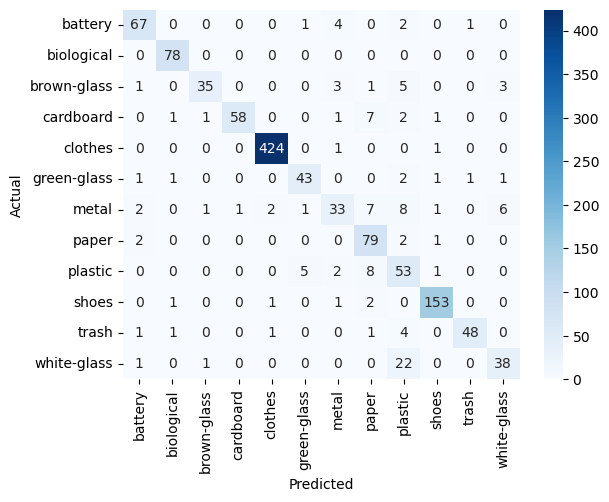

Test Accuracy: 89.51%


In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

model = tf.keras.models.load_model(r'C:\Users\kethu\Videos\data-set\Saved_model\ResNet50.h5')

# Prediction and Confusion Matrix
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob = []
y_act = []

test_generator.reset()
for _ in range(nb_samples):
    X_test, y_test = next(test_generator)
    y_prob.append(model.predict(X_test))
    y_act.append(y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

# Create a DataFrame for the actual vs predicted classes
out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class', 'actual_class'])

# Confusion Matrix
confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

# Plot Confusion Matrix
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, fmt='d')
plt.show()

# Print test accuracy
accuracy = np.diag(confusion_matrix).sum() / confusion_matrix.sum().sum() * 100
print(f'Test Accuracy: {accuracy:.2f}%')


# Test prediction

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = tf.keras.models.load_model(r'C:\Users\kethu\Videos\data-set\Saved_model\ResNet50.h5')

# Define the class names (Replace with your actual class names)
class_names = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass',
               'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass'] 

# Function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size=(244, 244)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)  # Use ResNet-specific preprocessing
    return img_array

# List of image paths to test
img_paths = [
    r'C:\Users\kethu\Videos\data-set\shirt.jpg',
    r'C:\Users\kethu\Videos\data-set\food.jpg'
]

# Loop through each image path and make predictions
for img_path in img_paths:
    # Load and preprocess the image
    img = load_and_preprocess_image(img_path)

    # Make a prediction
    predictions = model.predict(img)

    # Get the predicted class index and confidence
    predicted_class_index = np.argmax(predictions[0])
    confidence = np.max(predictions[0]) * 100

    # Get the class name from the index
    predicted_class_name = class_names[predicted_class_index]

    # Display the results for each image
    print(f"Image: {img_path}")
    print(f"Predicted Class: {predicted_class_name}, Confidence: {confidence:.2f}%\n")



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Image: C:\Users\kethu\Videos\data-set\shirt.jpg
Predicted Class: clothes, Confidence: 100.00%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Image: C:\Users\kethu\Videos\data-set\food.jpg
Predicted Class: biological, Confidence: 100.00%

